In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, cross_val_predict
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [118]:
column_names=[
    'age', 'class', 'ind_code_det', 'occ_code_det', 'education', 'wage_hr', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'cap_gain', 'cap_loss', 'dividend', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'inst_weight', 'migr_change_msa', 'migr_change_reg', 'migr_move_msa', 'lived_1yr',
    'migr_sunbelt', 'num_ppl_worked', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'weeks_worked', 'year', 'income']

train = pd.read_csv('census-income.data',header=None)
train.columns=column_names
test = pd.read_csv('census-income.test',header=None)
test.columns=column_names

train.drop(['migr_change_msa','migr_change_reg','migr_move_msa','migr_sunbelt'],axis = 1,inplace=True)
train.dropna(inplace=True)
test.drop(['migr_change_msa','migr_change_reg','migr_move_msa','migr_sunbelt'],axis = 1,inplace=True)
test.dropna(inplace=True)

train.head(2)

,age,class,ind_code_det,occ_code_det,education,wage_hr,enroll_edu,marital,ind_code_maj,occ_code_maj,...,birth_dad,birth_mom,birth_self,citizenship,employed_status,veteran_admin,veteran_benefit,weeks_worked,year,income
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.


In [119]:
predictors = [
    'age', 'class', 'ind_code_det', 'occ_code_det', 'education', 'wage_hr', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'cap_gain', 'cap_loss', 'dividend', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'inst_weight', 'lived_1yr',
    'num_ppl_worked', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'weeks_worked', 'year']

In [120]:
categorical_predictors = [
    'class', 'ind_code_det', 'occ_code_det', 'education', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum',  'lived_1yr', 'fam_members_u18', 'birth_dad', 
    'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'year']

In [121]:
train['>50K'] = train['income'].apply(lambda x: 1 if x == ' 50000+.' else 0)
test['>50K'] = test['income'].apply(lambda x: 1 if x == ' 50000+.' else 0)
X_train = train[predictors]
y_train = train['>50K']
X_test = test[predictors]
y_test = test['>50K']
X_train.head(2)

,age,class,ind_code_det,occ_code_det,education,wage_hr,enroll_edu,marital,ind_code_maj,occ_code_maj,...,fam_members_u18,birth_dad,birth_mom,birth_self,citizenship,employed_status,veteran_admin,veteran_benefit,weeks_worked,year
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94


In [122]:
# one-hot encoding 
combined_X = pd.concat([X_train, X_test], axis=0)
X_encoded = pd.get_dummies(combined_X, columns=categorical_predictors, dtype=int)
X_train_encoded = X_encoded.iloc[:len(X_train)]
X_test_encoded = X_encoded.iloc[len(X_train):]

In [123]:
X_train_encoded.shape

(199523, 478)

In [124]:
X_test_encoded.shape

(99762, 478)

In [ ]:
X_train_encoded.isnull().sum()

# Feature Engineering

In [126]:
#Removing quasi-constant features
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.01)  # 0.1 indicates 99% of observations approximately
sel.fit(X_train_encoded)  # fit finds the features with low variance
sum(sel.get_support())

175

In [127]:
sel_idx = X_train_encoded.columns[sel.get_support()]
sel_idx

Index(['age', 'wage_hr', 'cap_gain', 'cap_loss', 'dividend', 'inst_weight',
       'num_ppl_worked', 'weeks_worked', 'class_ Federal government',
       'class_ Local government',
       ...
       'citizenship_ Foreign born- Not a citizen of U S ',
       'citizenship_ Foreign born- U S citizen by naturalization',
       'citizenship_ Native- Born in the United States', 'employed_status_0',
       'employed_status_1', 'employed_status_2', 'veteran_benefit_0',
       'veteran_benefit_2', 'year_94', 'year_95'],
      dtype='object', length=175)

In [ ]:
# finally we can print the quasi-constant features
print(
    len([
        x for x in X_train_encoded.columns
        if x not in X_train_encoded.columns[sel.get_support()]
    ]))

[x for x in X_train_encoded.columns if x not in X_train_encoded.columns[sel.get_support()]]

In [129]:
# we can then remove the features from training and test set
X_train_encoded = sel.transform(X_train_encoded)
X_test_encoded = sel.transform(X_test_encoded)
# check the shape of training and test set
X_train_encoded.shape, X_test_encoded.shape

((199523, 175), (99762, 175))

In [130]:
X_train_encoded = pd.DataFrame(X_train_encoded, columns=sel_idx)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=sel_idx)
X_train_encoded.head(2)

,age,wage_hr,cap_gain,cap_loss,dividend,inst_weight,num_ppl_worked,weeks_worked,class_ Federal government,class_ Local government,...,citizenship_ Foreign born- Not a citizen of U S,citizenship_ Foreign born- U S citizen by naturalization,citizenship_ Native- Born in the United States,employed_status_0,employed_status_1,employed_status_2,veteran_benefit_0,veteran_benefit_2,year_94,year_95
0,73.0,0.0,0.0,0.0,0.0,1700.09,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,58.0,0.0,0.0,0.0,0.0,1053.55,1.0,52.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


# Decision Tree

In [38]:
#Defining the object to build a regression tree
dt_model1 = DecisionTreeClassifier(random_state=1) 
#Fitting the regression tree to the data
dt_model1.fit(X_train_encoded, y_train)
print(dt_model1.get_n_leaves())
print(dt_model1.get_depth())

10103
54


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Accuracy:  99.9994988046491
ROC-AUC:  0.9999999997842205
Precision:  1.0
Recall:  0.9999192376029721


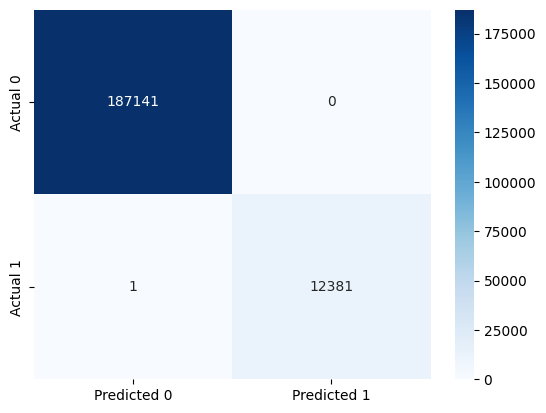

In [172]:
# Performance metrics computation 
#train
#Computing the accuracy
y_pred = dt_model1.predict(X_train_encoded)
print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing the ROC-AUC
y_pred_prob = dt_model1.predict_proba(X_train_encoded)[:,1]
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Accuracy:  93.20482748942483
ROC-AUC:  0.7238776226980972
Precision:  0.45513693448328035
Recall:  0.4862592951826705


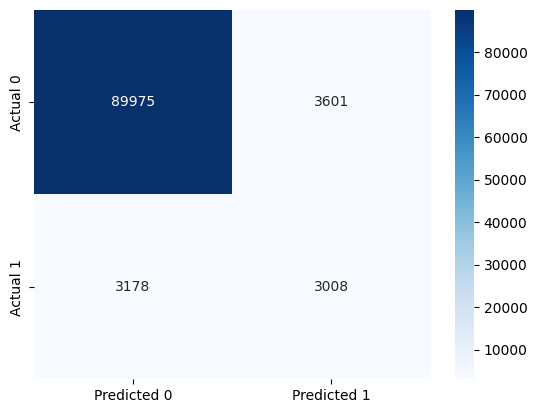

In [173]:
#test
#Computing the accuracy
y_pred = dt_model1.predict(X_test_encoded)
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
y_pred_prob = dt_model1.predict_proba(X_test_encoded)[:,1]
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [179]:
# Course Grid Search
param_grid = {    
    'max_depth': range(5,51,5),
    'max_leaf_nodes': range(3,51,5),
    'max_features': range(1, 21, 4)
}

#Grid search to optimize parameter values
skf = StratifiedKFold(n_splits=10)#The folds are made by preserving the percentage of samples for each class.

#Minimizing FNR is equivalent to maximizing recall
grid_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=1), param_grid, scoring=['precision','recall'], 
                           refit="recall", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train_encoded, y_train)

# make the predictions
y_pred = grid_search.predict(X_test_encoded)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [180]:
print('Train accuracy : %.3f'%grid_search.best_estimator_.score(X_train_encoded, y_train))
print('Test accuracy : %.3f'%grid_search.best_estimator_.score(X_test_encoded, y_test))
print('Train accuracy : %.3f'%grid_search.best_estimator_.score(X_train_encoded, y_train))
print('Test accuracy : %.3f'%grid_search.best_estimator_.score(X_test_encoded, y_test))
print('Best accuracy Through Grid Search : %.3f'%grid_search.best_score_)

y_train_pred = grid_search.best_estimator_.predict(X_train_encoded)
train_recall = recall_score(y_train, y_train_pred)
print('Train recall : %.3f' % train_recall)
y_test_pred = grid_search.best_estimator_.predict(X_test_encoded)
test_recall = recall_score(y_test, y_test_pred)
print('Test recall : %.3f' % test_recall)

print('Best params for recall')
print(grid_search.best_params_)

Train accuracy : 0.946
Test accuracy : 0.946
Train accuracy : 0.946
Test accuracy : 0.946
Best accuracy Through Grid Search : 0.281
Train recall : 0.221
Test recall : 0.215
Best params for recall
{'max_leaf_nodes': 48, 'max_features': 13, 'max_depth': 30}


In [181]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_leaf_nodes,param_max_features,param_max_depth,params,split0_test_precision,split1_test_precision,...,split3_test_recall,split4_test_recall,split5_test_recall,split6_test_recall,split7_test_recall,split8_test_recall,split9_test_recall,mean_test_recall,std_test_recall,rank_test_recall
0,0.782508,0.039585,0.040044,0.005566,43,9,50,"{'max_leaf_nodes': 43, 'max_features': 9, 'max...",0.707196,0.804560,...,0.248788,0.222132,0.228595,0.260097,0.235864,0.162359,0.176898,0.226454,0.038078,4
1,0.954367,0.095139,0.049679,0.012392,43,13,45,"{'max_leaf_nodes': 43, 'max_features': 13, 'ma...",0.675978,0.697719,...,0.284330,0.206785,0.290792,0.275444,0.285137,0.289984,0.291599,0.277742,0.025341,2


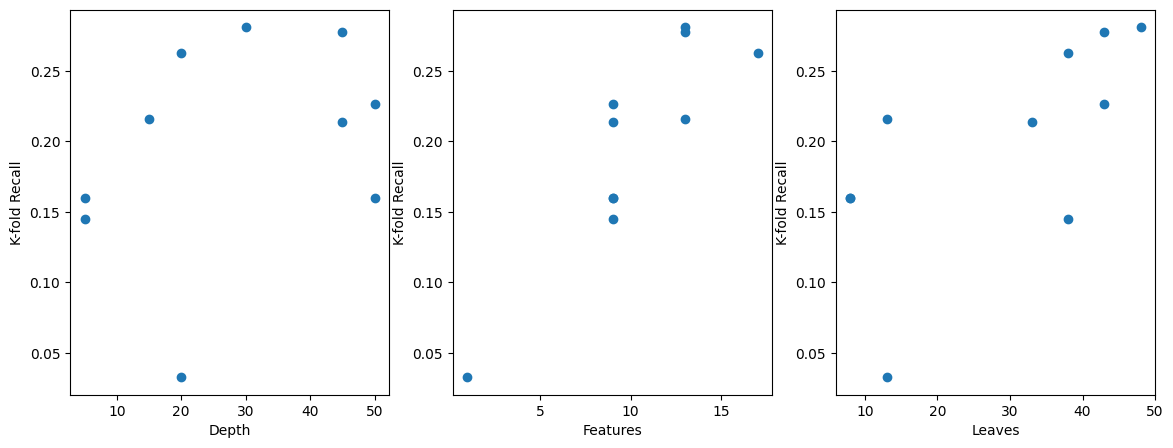

In [182]:
fig, axes = plt.subplots(1,3,figsize=(14,5))
plt.subplots_adjust(wspace=0.2)
axes[0].plot(cv_results.param_max_depth, cv_results.mean_test_recall, 'o')
axes[0].set_xlabel('Depth')
axes[0].set_ylabel('K-fold Recall')
axes[1].plot(cv_results.param_max_features, cv_results.mean_test_recall, 'o')
axes[1].set_xlabel('Features')
axes[1].set_ylabel('K-fold Recall');
axes[2].plot(cv_results.param_max_leaf_nodes, cv_results.mean_test_recall, 'o')
axes[2].set_xlabel('Leaves')
axes[2].set_ylabel('K-fold Recall');

In [183]:
#Finer Grid 
# From Course Grid {'max_leaf_nodes': 48, 'max_features': 13, 'max_depth': 30}
param_grid = {    
    'max_depth': range(26,33,2),
    'max_leaf_nodes': range(46,53,2),
    'max_features': range(15, 20, 2)
}

#Grid search to optimize parameter values
import time as time
start_time = time.time()
skf = StratifiedKFold(n_splits=5)#The folds are made by preserving the percentage of samples for each class.

#Minimizing FNR is equivalent to maximizing recall
grid_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=1), param_grid, scoring=['precision','recall'], 
                           refit="recall", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train_encoded, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
                   param_distributions={'max_depth': range(26, 33, 2),
                                        'max_features': range(15, 20, 2),
                                        'max_leaf_nodes': range(46, 53, 2)},
                   refit='recall', scoring=['precision', 'recall'],
                   verbose=True)

In [184]:
print(grid_search.best_params_)

{'max_leaf_nodes': 46, 'max_features': 17, 'max_depth': 32}


Accuracy:  94.66831057917845
ROC-AUC:  0.8968410059230509
Precision:  0.6958879349299594
Recall:  0.24894924021985126


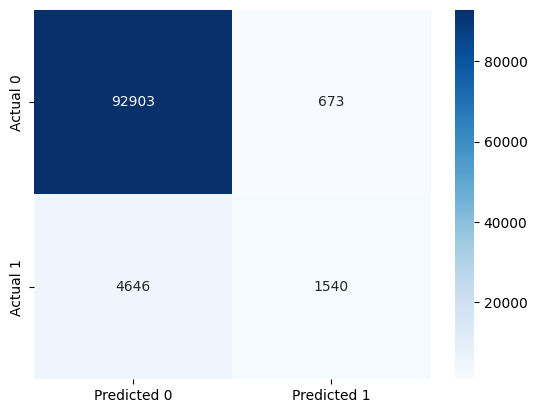

In [185]:
dt_final = grid_search.best_estimator_

# Performance metrics computation 
#Computing the accuracy
y_pred = dt_final.predict(X_test_encoded)
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
y_pred_prob = dt_final.predict_proba(X_test_encoded)[:,1]
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

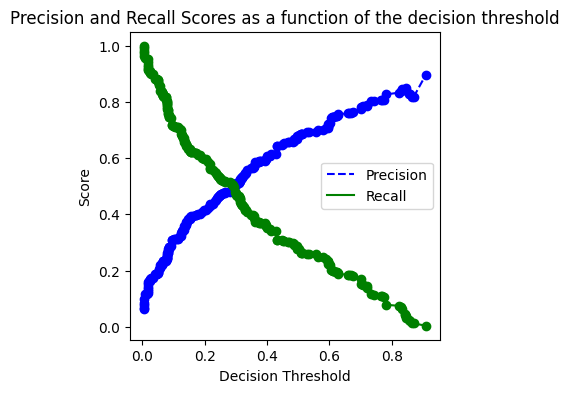

In [186]:
#threshold tuning 
cross_val_ypred = cross_val_predict(dt_final, X_train_encoded, 
                                              y_train, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(4, 4))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

Accuracy:  81.92438966936143
ROC-AUC:  0.896972183120069
Precision:  0.22776283421845184
Recall:  0.8001130673558391


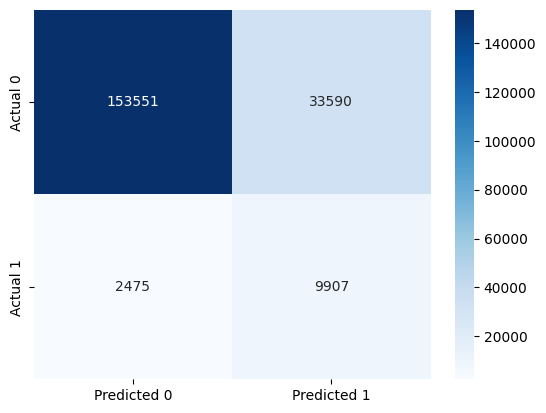

In [192]:
#threshold tuning 
#train
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.08

y_pred_prob = dt_final.predict_proba(X_train_encoded)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  81.9350053126441
ROC-AUC:  0.8968410059230509
Precision:  0.2283077770636305
Recall:  0.8039120594891691


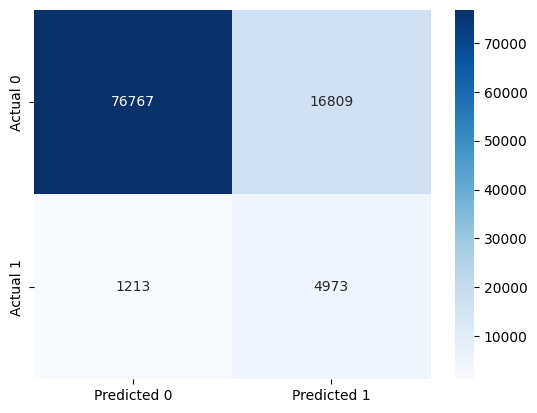

In [194]:
#threshold tuning 
#test
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.08

y_pred_prob = dt_final.predict_proba(X_test_encoded)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

# Decision Tree with Cost Complexity Tuning

In [131]:
# decision tree cost complexity pruning 
ccp_model = DecisionTreeClassifier(random_state = 1)#model without any restrictions
path= ccp_model.cost_complexity_pruning_path(X_train_encoded, y_train)# Compute the pruning path during Minimal Cost-Complexity Pruning.

In [132]:
alphas=path['ccp_alphas']
len(alphas)

3578

In [133]:
#Grid search to optimize parameter values
skf = StratifiedKFold(n_splits=5)
grid_search = RandomizedSearchCV(DecisionTreeClassifier(random_state = 1), param_distributions = {'ccp_alpha':alphas}, 
                                                  scoring=['precision','recall','accuracy'], 
                                                  refit="recall", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train_encoded, y_train)

# make the predictions
y_pred = grid_search.predict(X_test_encoded)
print('Best params for recall')
print(grid_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params for recall
{'ccp_alpha': 3.3279605950465424e-06}


In [134]:
# Model with the optimal value of 'ccp_alpha'
ccp_model = DecisionTreeClassifier(ccp_alpha=3.3279605950465424e-06,random_state=1)
ccp_model.fit(X_train_encoded, y_train)

DecisionTreeClassifier(ccp_alpha=3.3279605950465424e-06, random_state=1)

Accuracy:  93.34716625568853
ROC-AUC:  0.6968491075206681
Precision:  0.46498990839931686
Recall:  0.4841577756223731


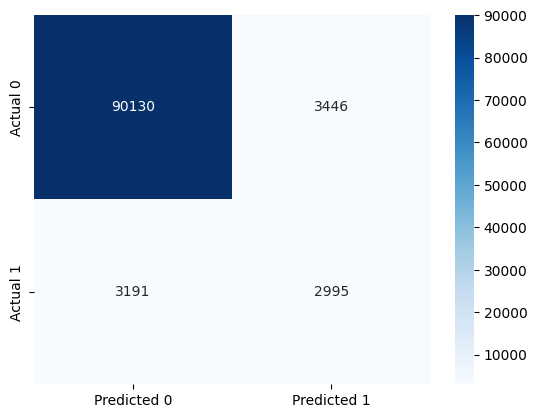

In [196]:
# Performance metrics computation 
#Computing the accuracy
y_pred = ccp_model.predict(X_test_encoded)
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
y_pred_prob = ccp_model.predict_proba(X_test_encoded)[:,1]
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

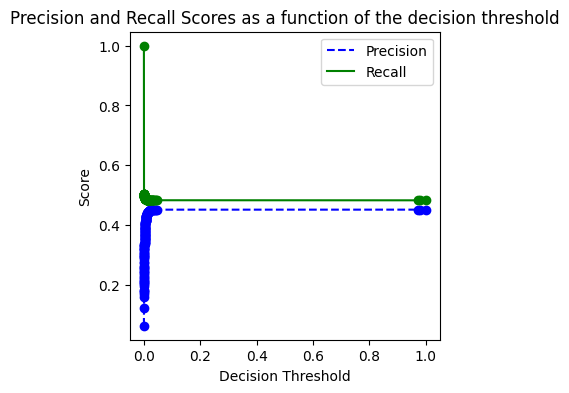

In [137]:
#threshold tuning 
cross_val_ypred = cross_val_predict(ccp_model, X_train_encoded, 
                                              y_train, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(4, 4))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

Accuracy:  97.39177939385434
ROC-AUC:  0.9991818667031037
Precision:  0.7067158161502131
Recall:  0.9909546115328703


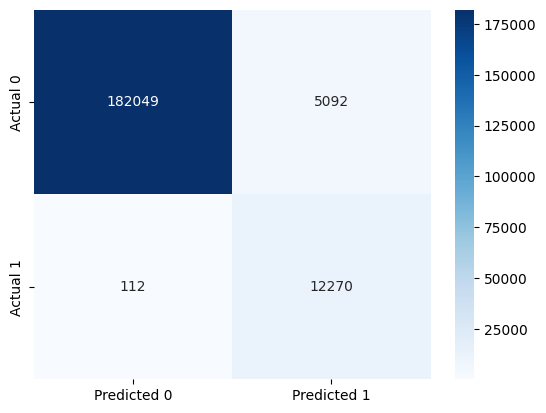

In [197]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.01

y_pred_prob = ccp_model.predict_proba(X_train_encoded)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  91.17098694893848
ROC-AUC:  0.6968491075206681
Precision:  0.35484942426926486
Recall:  0.5181053992887165


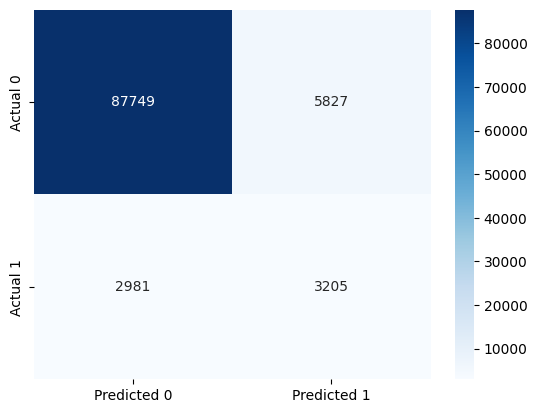

In [198]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.01

y_pred_prob = ccp_model.predict_proba(X_test_encoded)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

# Random Forest

In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score

import itertools as it
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score

import itertools as it
import time as time

In [98]:
# Random Forest Base Model 
rf_model1 = RandomForestClassifier(random_state=0)
rf_model1.fit(X_train_encoded, y_train)
y_pred = rf_model1.predict(X_test_encoded)
accuracy_score(y_test, y_pred)
recall_score(y_test, y_pred)

0.39637892014225673

In [100]:
# Feature Importance 
feature_scores = pd.Series(rf_model1.feature_importances_, index=X_train_encoded.columns).sort_values(ascending=True)

feature_scores

fam_members_u18_ Mother only present                0.000007
enroll_edu_ High school                             0.000066
fam_state_ Child <18 never marr not in subfamily    0.000141
fam_state_sum_ Child under 18 never married         0.000259
enroll_edu_ College or university                   0.000279
                                                      ...   
num_ppl_worked                                      0.037233
cap_gain                                            0.074209
dividend                                            0.076921
age                                                 0.082465
inst_weight                                         0.084678
Length: 175, dtype: float64

In [138]:
#Course Grid
parameters = {'max_depth':range(5,31,5),
              'max_leaf_nodes':range(5,51,10),
              'max_features':range(10,51,10), 
              'n_estimators': range(50, 251, 50),
             'max_samples':[0.25,0.5,0.75]}
cv = KFold(n_splits = 5,shuffle=True,random_state=1)
rf_model2 = RandomizedSearchCV(RandomForestClassifier(random_state=1, n_jobs=-1), parameters, 
                     scoring=['accuracy','recall'], refit='recall',
                            cv=cv, n_jobs=-1, verbose = True)
rf_model2.fit(X_train_encoded, y_train)
print("Best Accuracy:", rf_model2.best_score_, "Best Parameters:",rf_model2.best_params_)#Course Grid

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Accuracy: 0.3000570903330732 Best Parameters: {'n_estimators': 150, 'max_samples': 0.25, 'max_leaf_nodes': 45, 'max_features': 50, 'max_depth': 25}


In [139]:
#Finer Grid
parameters = {'max_depth':range(23,28),
              'max_leaf_nodes':range(43,49,2),
              'max_features':range(45,55,2), 
              'n_estimators': range(140, 160, 5),
             'max_samples':[0.20, 0.25, 0.30]}
cv = KFold(n_splits = 5,shuffle=True,random_state=1)
rf_model2 = RandomizedSearchCV(RandomForestClassifier(random_state=1, n_jobs=-1), parameters, 
                     scoring=['accuracy','recall'], refit='recall',
                            cv=cv, n_jobs=-1, verbose = True)
rf_model2.fit(X_train_encoded, y_train)
print("Best Accuracy:", rf_model2.best_score_, "Best Parameters:",rf_model2.best_params_)#Course Grid

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Accuracy: 0.3064408174309118 Best Parameters: {'n_estimators': 150, 'max_samples': 0.2, 'max_leaf_nodes': 47, 'max_features': 53, 'max_depth': 27}


Accuracy:  95.15146047593272
ROC-AUC:  0.9373118996193934
Precision:  0.7763211798443261
Recall:  0.3063368897510508


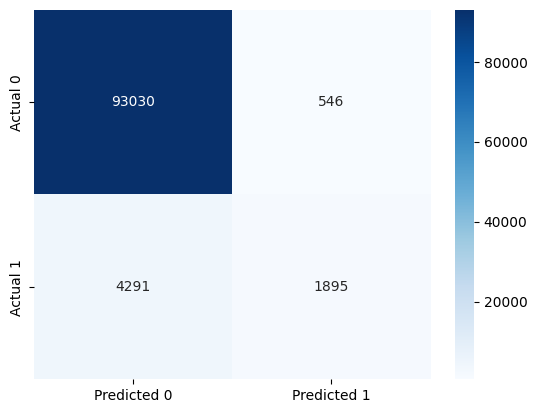

In [159]:
rf_final = rf_model2.best_estimator_

# Performance metrics computation 
#Computing the accuracy
y_pred = rf_final.predict(X_test_encoded)
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
y_pred_prob = rf_final.predict_proba(X_test_encoded)[:,1]
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

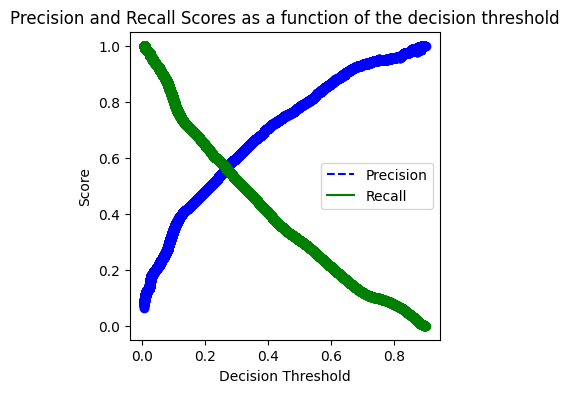

In [160]:
#threshold tuning 
cross_val_ypred = cross_val_predict(rf_final, X_train_encoded, 
                                              y_train, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(4, 4))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

Accuracy:  89.41625777479288
ROC-AUC:  0.9370575925538576
Precision:  0.34762585912151556
Recall:  0.8047165239864319


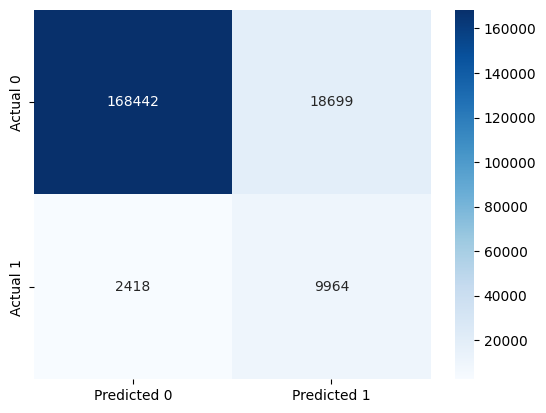

In [199]:
# train
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.1

y_pred_prob = rf_final.predict_proba(X_train_encoded)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  89.31757583047654
ROC-AUC:  0.9373118996193934
Precision:  0.3447892800111088
Recall:  0.8027804720336243


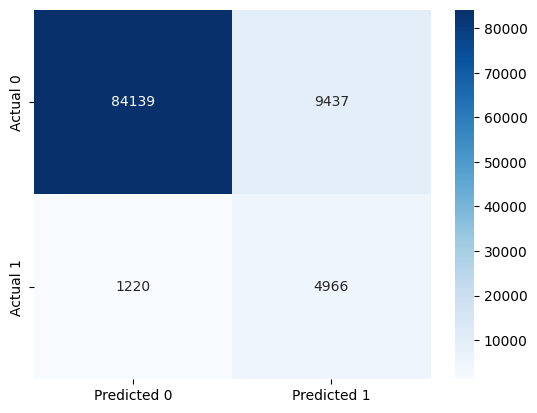

In [200]:
#test 
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.1

y_pred_prob = rf_final.predict_proba(X_test_encoded)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [201]:
# Feature Importance 
feature_scores = pd.Series(rf_final.feature_importances_, index=X_train_encoded.columns).sort_values(ascending=False)

feature_scores

cap_gain                                       0.232940
dividend                                       0.166112
weeks_worked                                   0.091143
occ_code_maj_ Professional specialty           0.061478
sex_ Female                                    0.054711
                                                 ...   
occ_code_det_32                                0.000000
lived_1yr_ Yes                                 0.000000
fam_members_u18_ Both parents present          0.000000
fam_members_u18_ Mother only present           0.000000
fam_state_sum_ Child under 18 never married    0.000000
Length: 175, dtype: float64